<a href="https://colab.research.google.com/github/Kyyza/PortfolioOptimisation/blob/main/Portfolio_Allocation_and_VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio allocation

When you look at popular cryptocurrency price information websites such as [Coin Market Cap](https://coinmarketcap.com/) or [Coin Gecko](https://www.coingecko.com), you will often be presented with a list of the most popular crypto-assets, ordered by Market Capitalisation.

A typical way to gain exposure to a new asset class would be to purchase those assets that make up the top *n* of the index. In doing so, you might ask:

*What allocation of these assets would make the best return?*

But in constructing a portfolio, it is not only the expected return that should be considered.

Given the highly volatile nature of cryptocurrencies in today's market, maybe the better question would be:

*What allocation of these assets would make me the best **risk adjusted** return?*

That is, which portfolio would give me the biggest returns, for the least amount of loss?

This notebook concerns itself with this very question. We consider the Value at Risk (VaR) score for two methods of portfolio construction on an arbitrary set of cryptocurrencies.

**Portfolios**

1. Equally weighted
2. Market Cap weighted


We employ the Variance-covariance method of calculating VaR and assume a Normal Guassian distribution - which we will later show that is not entirely accurate, but is workable for this analysis and is something that could be built on in later work.

--------------------------

In constructing these portfolios we will:


*   Source historic price data for a group of 10 arbitrary coins
*   Apply either an (1) equal weighting, or a (2) Market Cap weighted allocation to the assets
*   Explore the probability density distribution of their respective returns
*   Calculate the Value at Risk for each portfolio
*   Compare the VaR to see which construct offers the best risk-adjusted returns

### Data

We start by collecting and formatting historic crypto-currency data from an open [API provided by Coin Gecko](https://www.coingecko.com/en/api).

We collect historic ``Price``, ``Market Cap`` and ``Volume`` for the 3.25 year period: 01/01/2018 to 30/04/2021.

Which, admittedly encapsulates a record bull run, but when dealing with the crypto-currency market, looking back further than this could be unreliable as the market is rapidly changing with new technologies and products being released monthly.

### **Get data**

Coin gecko api 

In [ ]:
# install pycoingecko library if not already
!pip install pycoingecko

In [ ]:
# import other libraries used
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

from scipy.stats import norm

from pycoingecko import CoinGeckoAPI # crypto data provider

# set a visualisation style for the whole notebook
plt.style.use('seaborn')

In [ ]:
# initiate connection to the CoinGecko API
cg = CoinGeckoAPI()
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

##### Define 'Get Data' functions

In [ ]:
# build functions

# base function to call api for historical data
def getCryptoData(coin, from_unix, to_unix, currency):
  """
  Gets Price, Market Cap & Volume data for the coin and date range specified.
  Note that the frequency of return is based on the range asked for
  as specified here: https://www.coingecko.com/en/api#explore-api
  To get daily data, you need to call for 91+ days.

  :params:
  coin      | str | Coin ID to query.
  from_unix | int | Unix date representing the first date in the query range.
  to_unix   | int | Unix date representing the end date in the query range.
  currency  | str | Base currency representing the FX pair for coin.

  :returns:
  df | Pandas DataFrame | Formatted data for the queried coin.
  """

  # send query to api
  data = cg.get_coin_market_chart_range_by_id(
      id=coin, 
      vs_currency=currency,
      from_timestamp=from_unix,
      to_timestamp=to_unix
      )
  # create pandas DataFrame
  df = pd.DataFrame(data)

  # label the asset in the dataframe
  df['id'] = coin
  # unpack the data pairs
  df[['Date', 'Price']] = pd.DataFrame(df.prices.tolist(), index=df.index)
  df[['Date', 'MarketCap']] = pd.DataFrame(df.market_caps.tolist(), index=df.index)
  df[['Date', 'Volume']] = pd.DataFrame(df.total_volumes.tolist(), index=df.index)

  # drop raw columns
  df.drop(columns=['prices', 'market_caps', 'total_volumes'], inplace=True)
  # apply datetime dtype
  df['Date'] = pd.to_datetime(df['Date'], unit='ms')

  return df

# lets you iterate through a list of coin ID's to get data for all
def collateCryptoData(coins, from_unix, to_unix, currency):
  """
  Calls getCryptoData for all coins in a list. Collates all the data into one
  DataFrame.

  :params:
  coins     | list of str | Coin IDs to query.
  from_unix | int | Unix date representing the first date in the query range.
  to_unix   | int | Unix date representing the end date in the query range.
  currency  | str | Base currency representing the FX pair for coin.

  :returns:
  df | Pandas DataFrame | Formatted data for the queried coins, with Date 
  set as the index.
   
  """

  # define an empty dataframe to fill later
  allCoinsData = pd.DataFrame()

  # loop over the coins and get the data
  for coin in coins:
    temp_df = getCryptoData(
        coin=coin,
        from_unix=from_unix,
        to_unix=to_unix,
        currency=currency
    )

    # add to all coins df
    allCoinsData = allCoinsData.append(temp_df)

  # set index to the Date col
  allCoinsData.set_index('Date', inplace=True)

  return allCoinsData


# convert datetimes to unix
def toUnix(date):
  """
  Converts a Datetime value to a Unix time.

  :params:
  datetime | datetime.Datetime | Original value to be converted.

  :returns:
  unixtime | int | Datetime converted into Unix time in seconds.
  """

  # define the start of unix time
  startUnix = datetime(1970,1,1)

  # unix time is the difference between the given date
  # and the start of time, in seconds
  unixtime = (date - startUnix).total_seconds()

  return unixtime

# convert datetimes to unix
def fromUnix(unixtime):
  """
  Converts a Unix time value to a datetime.

  :params:
  unixtime | int | Unix time to be converted.

  :returns:
  _ | int | Unix time converted into datetime.
  """

  return datetime.utcfromtimestamp(unixtime).strftime(
      '%d-%m-%Y %H:%M:%S'
  )

##### Configure & run data collection

In [ ]:
# get data config
from_date = datetime(2018,1,1)
to_date   = datetime(2021,4,30) # 3.25 years of data
# convert dates to unix time
from_unix = toUnix(from_date)
to_unix   = toUnix(to_date)

# define coins to query
query_coins = [
               'bitcoin',
               'ethereum',
               'ripple',
               'tether',
               'litecoin',
               'binancecoin',
               'monero',
               'stellar',
               'cardano',
               'bitcoin-cash',
]

In [ ]:
# get data for each coin
coins_df = collateCryptoData(
    coins = query_coins,
    from_unix = from_unix,
    to_unix = to_unix,
    currency = 'gbp',
)
print('-------Describe-------')
print(coins_df.describe())
print('---------Info---------')
print(coins_df.info())
print('---------Head---------')
print(coins_df.head())

-------Describe-------
              Price     MarketCap        Volume
count  12158.000000  1.215800e+04  1.215800e+04
mean    1033.248553  2.517176e+10  5.544624e+09
std     4010.893435  7.462774e+10  1.244923e+10
min        0.018871  3.252142e+08  4.218953e+02
25%        0.321308  1.739178e+09  1.483752e+08
50%       30.661942  3.703692e+09  8.027225e+08
75%      179.885128  1.359713e+10  3.563764e+09
max    46196.720112  8.630454e+11  1.681301e+11
---------Info---------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12158 entries, 2018-01-01 00:00:00 to 2021-04-30 00:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         12158 non-null  object 
 1   Price      12158 non-null  float64
 2   MarketCap  12158 non-null  float64
 3   Volume     12158 non-null  float64
dtypes: float64(3), object(1)
memory usage: 474.9+ KB
None
---------Head---------
                 id         Price     MarketCap        Vo

To make calculating the returns easier later on, we can isolate the prices and pivot the dataframe so that it shows the price for each coin along the columns, for each date in the rows.

In [ ]:
# create a copy of the dataframe to work with
prices_df = coins_df.copy()

# for this view, we only care about the Price data for each asset id
# so let's drop the other columns and make a new df
prices_df = prices_df[['id','Price']]

# we reset the date index so we can more easily access the dates
prices_df = prices_df.reset_index()

# pivot the dataframe so that the coin id's become the columns
# and the Price per day are the values
prices_df = prices_df.pivot(
    index='Date', 
    columns='id', 
    values='Price'
    )

# let's see what that looks like
prices_df

id,binancecoin,bitcoin,bitcoin-cash,cardano,ethereum,litecoin,monero,ripple,stellar,tether
Date,,,,,,,,,,
2018-01-01,6.532149,10428.240221,1795.780689,0.552719,574.242791,170.525145,264.286858,1.709320,0.367598,0.746696
2018-01-02,6.685984,11269.281612,1932.178315,0.593865,644.952785,187.587940,276.941463,1.805866,0.407318,0.738383
2018-01-03,7.316937,11533.742774,1946.860205,0.795809,712.764302,183.577764,292.536746,2.313360,0.648010,0.751786
2018-01-04,7.139296,11788.224964,1814.305048,0.870186,721.928236,180.652021,306.233757,2.375927,0.557204,0.739925
2018-01-05,12.153443,13515.870875,1880.540944,0.794446,740.693011,187.321695,296.684554,2.160676,0.518331,0.736860
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,364.837843,35313.464061,545.764093,0.781973,1663.501663,161.459831,256.413122,0.746058,0.300911,0.723482
2021-04-27,383.956033,38844.012133,610.551629,0.888476,1822.254896,177.621707,289.190225,0.978831,0.349628,0.720015
2021-04-28,409.219785,39551.927965,637.016901,0.938682,1903.923526,186.179317,288.701278,1.007826,0.365347,0.717003


## Portfolio Construction

Construct the weights that will define our portfolios.

For the equal weighting - the weights are simply $1/N$.

For the Market Cap weighting, we will need to use the original dataframe to access the Market Cap info.

In [ ]:
# count number of assets
n = len(prices_df.columns)
# define equal weights for each asset
eq_w = np.array([1/n for i in range(n)])

print("Weights:\n\t{}".format(eq_w))

Weights:
	[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


### Market Cap weighted

For this analysis, we are selecting a rebalancing period of 1 day. This means that we will recalculate the weights for each asset for each date in our range.

We need to calculate the percentage weight of each asset's Market Cap for each date, compared to it's peers.

From there, we will take the average of each coin's weighting across the period to form our notional weights which we can use in a standard VaR calculation.

In [ ]:
# create a copy of the dataframe to work with our portfolio
marketCapWeighted = coins_df.copy()
# we reset the date index so we can more easily access the dates
marketCaps = marketCapWeighted.reset_index()

# for the weights, we only need the Market Caps per coin per day
marketCaps = marketCaps[['Date', 'id', 'MarketCap']]

To calculate the daily weightings, we can divide each coin's Market Cap by the total sum of all coin's Market Cap for each date.

In [ ]:
# aggregate the Market Caps per date and coin
coins_mc_dates = marketCaps.groupby(['Date', 'id']).agg({'MarketCap': 'sum'})

# divide each coin's Market Cap by the total of the Caps, within each date
mc_w = coins_mc_dates.groupby(level=0).apply(lambda x:
                                         x / float(x.sum()) )
# show the resulting weights
mc_w

MarketCap
Date       id                     
2018-01-01 binancecoin    0.001782
           bitcoin        0.481940
           bitcoin-cash   0.083546
           cardano        0.039477
           ethereum       0.152989
...                            ...
2021-04-30 litecoin       0.010517
           monero         0.004492
           ripple         0.039624
           stellar        0.006986
           tether         0.031591

[12158 rows x 1 columns]

In [ ]:
# now we can unpack the weights from their multi-index
mc_w = mc_w.reset_index(['Date', 'id'])

# and pivot the dataframe so that the coin id's become the columns
# and the weight per day are the values
mc_w = mc_w.pivot(
    index='Date', 
    columns='id', 
    values='MarketCap'
    )

# lastly rename the MarketCap
mc_w.rename(columns={'MarketCap': 'weight'}, inplace=True)

# let's see what we end up with
mc_w

id,binancecoin,bitcoin,bitcoin-cash,cardano,ethereum,litecoin,monero,ripple,stellar,tether
Date,,,,,,,,,,
2018-01-01,0.001782,0.481940,0.083546,0.039477,0.152989,0.025636,0.011319,0.182413,0.018085,0.002814
2018-01-02,0.001685,0.481173,0.083050,0.039182,0.158761,0.026058,0.010963,0.178027,0.018530,0.002571
2018-01-03,0.001671,0.446408,0.075853,0.047590,0.159062,0.023120,0.010499,0.206705,0.026720,0.002372
2018-01-04,0.001609,0.450307,0.069765,0.051353,0.159014,0.022458,0.010848,0.209500,0.022673,0.002473
2018-01-05,0.002610,0.492064,0.068917,0.044678,0.155512,0.022198,0.010018,0.181557,0.020100,0.002346
...,...,...,...,...,...,...,...,...,...,...
2021-04-26,0.054366,0.636584,0.009853,0.024161,0.185494,0.010395,0.004425,0.033107,0.006653,0.034962
2021-04-27,0.051749,0.635683,0.010014,0.024963,0.184573,0.010386,0.004533,0.039458,0.007014,0.031628
2021-04-28,0.053901,0.630056,0.010176,0.025658,0.187690,0.010603,0.004407,0.039536,0.007140,0.030833


In [ ]:
# lastly we take the mean of each coin's weights across the period
# to create the weights array
mc_w = np.array(mc_w.mean())

mc_w

array([0.01418783, 0.6721772 , 0.03287117, 0.01572575, 0.14048139,
       0.02088392, 0.00870568, 0.07155597, 0.01399325, 0.02424757])

# Calculate returns

The value of the portfolio after any given period is defined by the change in it's price value over that time period.

Here we calculate the base returns that can be used in both of our portfolios later on.

In [ ]:
returns = prices_df.pct_change()

# the average of the returns is
mean_returns = returns.mean()

mean_returns

id
binancecoin     0.005756
bitcoin         0.001833
bitcoin-cash    0.001126
cardano         0.002238
ethereum        0.002309
litecoin        0.001470
monero          0.001464
ripple          0.001491
stellar         0.001866
tether          0.000061
dtype: float64

# Statistics for VaR

To calculate the Value at Risk, we need to be able to construct a Probability Density for our portfolio returns.

To do that we need the following statistics, relevant to the portfolio weightings:

* Mean return
* Standard deviation

We will use the [formulas provided in this article](https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/) to help derive these statistics.

## Mean (Expected Return)

The mean return of any portfolio is given by the means of the underlying assets multiplied by the weights.

$ E(pf) = M \cdot W $

This is where we need to start using our portfolio weights respectively.

In [ ]:
# for the equally weighted portfolio
eq_mean = np.dot(mean_returns, eq_w)
eq_mean

0.0019614954841163912

In [ ]:
# for the market cap weighted portfolio
mc_mean = np.dot(mean_returns, mc_w)
mc_mean

0.0018880283090693538

## Standard deviation (Volatility)

The standard deviation is calculated by:

$ S = \sqrt{s^2} $

Where $s^2$ is the variance given by:

$ s^2 = W^T * (Covariance Matrix) * W$

So, first we need to construct the Covariance matrix for our prices.

Then we calculate the variance, and take the square root to find the standard deviation.

In [ ]:
returns_cov = returns.cov()
returns_cov

id,binancecoin,bitcoin,bitcoin-cash,cardano,ethereum,litecoin,monero,ripple,stellar,tether
id,,,,,,,,,,
binancecoin,0.005362,0.001515,0.001863,0.001993,0.001883,0.001998,0.001683,0.001832,0.001922,0.000001
bitcoin,0.001515,0.001525,0.001821,0.001594,0.001583,0.001641,0.001487,0.001347,0.001470,-0.000010
bitcoin-cash,0.001863,0.001821,0.003986,0.002482,0.002439,0.002616,0.002199,0.002246,0.002321,-0.000005
cardano,0.001993,0.001594,0.002482,0.003647,0.002294,0.002229,0.001999,0.002280,0.002858,-0.000002
ethereum,0.001883,0.001583,0.002439,0.002294,0.002557,0.002195,0.001919,0.001971,0.002093,0.000012
litecoin,0.001998,0.001641,0.002616,0.002229,0.002195,0.002828,0.001954,0.002032,0.002064,-0.000004
monero,0.001683,0.001487,0.002199,0.001999,0.001919,0.001954,0.002727,0.001733,0.001884,-0.000020
ripple,0.001832,0.001347,0.002246,0.002280,0.001971,0.002032,0.001733,0.003980,0.002746,-0.000001
stellar,0.001922,0.001470,0.002321,0.002858,0.002093,0.002064,0.001884,0.002746,0.004076,-0.000007


In [ ]:
# calculate the standard deviation of the equally weighted portfolio
eq_S = np.sqrt(np.dot(eq_w.T, np.dot(returns_cov, eq_w)))
eq_S

0.04185237834060038

In [ ]:
# and the same for the Market Cap weighted portfolio
mc_S = np.sqrt(np.dot(mc_w.T, np.dot(returns_cov, mc_w)))
mc_S

0.03987545245761677

# Construct the Distribution Curve

To calculate, and also visualise, the VaR we need to construct a distribution curve for each of the portfolios.

In [ ]:
# we start by defining the X axes for both PDFs
x = np.arange(-0.15, 0.15, 0.001) # arbitrary dimensions to fit the distribution

# then we construct the normal distributions for each portfolio
eq_dist = norm.pdf(x, eq_mean, eq_S)
mc_dist = norm.pdf(x, mc_mean, mc_S)

Text(0.5, 1.0, 'Market Cap weighted')

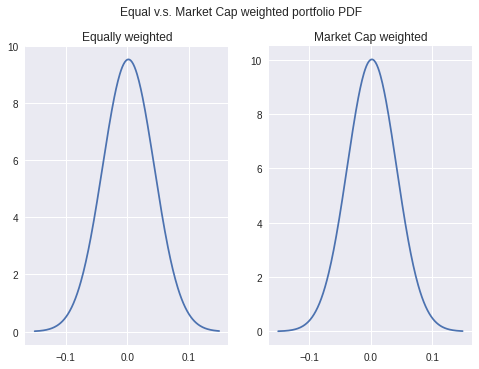

In [ ]:
# now we define our visualisation axes
# so that we can compare the portfolios side by side
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Equal v.s. Market Cap weighted portfolio PDF') # label the figure

# and plot the distributions
ax1.plot(x, eq_dist)
ax1.set_title('Equally weighted')
ax2.plot(x, mc_dist)
ax2.set_title('Market Cap weighted')

It seems that both portfolio's returns are very similar in distribution.

The skinny distribution here suggests that returns are quite stable across this historic price data.

# Calculating the Value at Risk

Value at Risk is understood at specific confidence levels.

For example, one might say:

*We are 95% confident that the portfolio will not lose more than x% in one day.*

So, lets start by calculating the VaR at the 95% confidence level, after that we can experiment with a few confidence levels and time ranges to see how that VaR changes.

In [ ]:
# set our confidence level as (1 - desired confidence)
conf_level = 0.05

# we use the Scipy Norm PPF (percent point function) to calculate
# the daily Value at Risk
# for each of the return distributions
eq_var = norm.ppf(conf_level, eq_mean, eq_S)
mc_var = norm.ppf(conf_level, mc_mean, mc_S)

# print the results
print("""
We are {conf}% confident that the...
----------
Equally weighted portfolio will not lose more than
{eq_var}% in a day.
----------
Market Cap weighted portfolio will not lose more than
{mc_var}% in a day.
""".format(conf=((1-conf_level)*100),
           eq_var=round(eq_var*100,2),
           mc_var=round(mc_var*100,2)
           )
)



We are 95.0% confident that the...
----------
Equally weighted portfolio will not lose more than
-6.69% in a day.
----------
Market Cap weighted portfolio will not lose more than
-6.37% in a day.



### Value at Risk for more than 1 day

To calculate the VaR for a time range greater than one day, all you have to do is multiply the VaR at 1 day by the square root of the number of days in the range you are interested in.

For example:

In [ ]:
# VaR at 10 days
days = 10
eq_var10D = eq_var * np.sqrt(days)

print("""
We are {conf}% confident that the...
----------
Equally weighted portfolio will not lose more than
{eq_var}% in {days} day(s).
""".format(conf=((1-conf_level)*100),
           eq_var=round(eq_var10D*100,2),
           days=days
           )
)


We are 95.0% confident that the...
----------
Equally weighted portfolio will not lose more than
-21.15% in 10 day(s).



## Let's generalise

Now that we have calculated the VaR specifically, let's create some functions to do that for us, and experiment with different parameters to give us a better view.

In [ ]:
def valueAtRisk(prices, weights, conf_level, days=1):
  """
  Calculates the Value at Risk for a given dataset of prices.

  :params:
  prices     | Pandas DataFrame | DataFrame of asset prices across a histroic period.
                                  Form should be of: Index = Dates, Columns = assets, Values = closing price
  weights    | numpy Array | Portfolio allocation percentages for each of the assets in 'prices'
                             Should be the same length as the columns in 'prices'
  conf_level | float | Confidence level required for the Value at Risk.
                      Should be the form of (1 - confidence level) if you are describing the upper bound.
  days       | int | Number of days to calculate the risk exposure for.

  :returns:
  var | float | Value of the Portfolio that is at risk for the given number of days.
   
  """
  # calculate the daily return of each asset in the portfolio
  returns = prices.pct_change()
  # the average return for each asset
  mean_returns = returns.mean()
  # the average return of the whole portfolio, weight allocated
  mean = np.dot(mean_returns, eq_w)

  # the covariance matrix of the returns
  returns_cov = returns.cov()

  # the standard deviation (volatility) of the portfolio
  stdev = np.sqrt(np.dot(weights.T, np.dot(returns_cov, weights)))

  # the value at risk for the number of days
  var = norm.ppf(conf_level, mean, stdev) * np.sqrt(days)

  return var


## VaR across a month

How does our VaR behave across a long date range?

We will use our above function ``valueAtRisk`` on both the portfolios, and see how the VaR changes across 30 days.

Text(0.5, 1.0, 'Market Cap weighted')

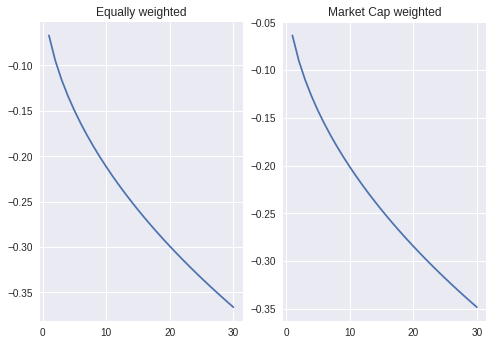

In [ ]:
# define a list of days we want to test the VaR on
days = range(1,31)

# initiate empty lists to fill with VaR values
eq_var = []
mc_var = []

# calculate the VaR for each day in the range
for day in days:
  # equally weighted pf
  eq_var.append(valueAtRisk(prices_df, eq_w, 0.05, days = day))
  # Market Cap weighted pf
  mc_var.append(valueAtRisk(prices_df, mc_w, 0.05, days = day))

# visualise the results
fig2, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Equal v.s. Market Cap weighted portfolio VaR over 30 days') # label the figure

# and plot the distributions
ax1.plot(days, eq_var)
ax1.set_title('Equally weighted')
ax2.plot(days, mc_var)
ax2.set_title('Market Cap weighted')

## What does this mean?

As seen above, the value at risk within both portfolios gets worse over time.

Specifically, the equally weighted portfolio performs worse than the portfolio that is weighted by Market Cap, but not by a significant amount.

### Optimization

Further work could be done to reduce the risk of these portfolios by optimising the weights given to each asset ina  way which minimises the VaR.

Some methods of approaching this could be to use Gradient Descent to minimise the VaR with respect to the weights, or a more simple Monte Carlo analysis to produce thousands of outcomes, and select the weights that produce the best VaR on the efficient frontier (a story for next time.

### Limitations

Standard covariance-variance VaR calculations such as the one used in this notebook rely on the assumption that returns are normally distributed with a mean of 0 and a given standard variation.

This means that we are assuming that our portfolio's returns have steadily stayed the same (and will continue to int he future) across the historic date range used when calculating the returns.

Statisticians often allow this assumption due to the law of averages suggesting that, given a wide enough time horizon and enough data, the distribution of the returns will indeed converge to a normal distribution.

However, within such a novel and volatile market as crypto currencies, it becomes difficult to make this assumption.

To overcome this in a future analysis we may conside using time-dependent estimations of the returns distribution using algorithms such as the GARCH models, or even delving into some Neural Networks using a Density Neural Netowkr architechture to capture temporal patterns in the data.